# Grapevine leaves classification, pre-trained models parts



    Reza Arabpour, 
    University of Tehran,
    Final version, Aug 2022.

## Environment Initialization

In [ ]:
#Loading General Tools and Libraries
import os
import random
import shutil
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
plt.style.use('ggplot')

## Data Loading

### Data Downloading

In [ ]:
#Loading Dataset
!rm -rf Grapevine_Leaves_Image_Dataset*
!rm -rf Test_Data
!wget https://www.muratkoklu.com/datasets/Grapevine_Leaves_Image_Dataset.zip
!unzip -q Grapevine_Leaves_Image_Dataset.zip 
!rm Grapevine_Leaves_Image_Dataset.zip
!ls -lh

--2022-08-06 06:26:31--  https://www.muratkoklu.com/datasets/Grapevine_Leaves_Image_Dataset.zip
Resolving www.muratkoklu.com (www.muratkoklu.com)... 185.179.25.150
Connecting to www.muratkoklu.com (www.muratkoklu.com)|185.179.25.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113862245 (109M) [application/zip]
Saving to: ‘Grapevine_Leaves_Image_Dataset.zip’

Grapevine_Leaves_Im 100%[===================>] 108.59M  20.7MB/s    in 6.3s    

2022-08-06 06:26:38 (17.4 MB/s) - ‘Grapevine_Leaves_Image_Dataset.zip’ saved [113862245/113862245]

total 8.0K
drwxr-xr-x 7 root root 4.0K Feb 11 17:53 Grapevine_Leaves_Image_Dataset
drwxr-xr-x 1 root root 4.0K Aug  3 20:21 sample_data


### Select and Move 20% of Data for OOS (Out Of Sample) Testing

In [ ]:
Species = ["Ak", "Ala_Idris", "Buzgulu", "Dimnit", "Nazli"]
OriginalDataPath = "Grapevine_Leaves_Image_Dataset"
TestDataPath = "Test_Data"
os.mkdir(os.path.join(TestDataPath,""))

for folder_name in Species:
  Percentage = 20/100
  Test_location = os.path.join(TestDataPath,folder_name)
  os.mkdir(Test_location)
  Original_location = os.path.join(OriginalDataPath, folder_name)
  AllImages = os.listdir(Original_location)
  Count = int(Percentage * len(AllImages))
  Selecteds = random.sample(AllImages, Count)
  for file in Selecteds:
    shutil.move(os.path.join(Original_location,file), Test_location)


### Datasets Loading (Train, Validation, and Test)

In [ ]:
image_size = (256,256)
batch_size = 32
validation_split = 0.2
seed = 199

train_data = tf.keras.utils.image_dataset_from_directory(
    'Grapevine_Leaves_Image_Dataset',
    class_names = ["Ak", "Ala_Idris", "Buzgulu", "Dimnit", "Nazli"],
    batch_size=batch_size,
    image_size=image_size,
    seed=seed,
    validation_split=validation_split,
    subset="training"
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    'Grapevine_Leaves_Image_Dataset',
    class_names = ["Ak", "Ala_Idris", "Buzgulu", "Dimnit", "Nazli"],
    batch_size=batch_size,
    image_size=image_size,
    seed=seed,
    validation_split=validation_split,
    subset="validation"
)

test_data = tf.keras.utils.image_dataset_from_directory(
    'Test_Data',
    class_names = ["Ak", "Ala_Idris", "Buzgulu", "Dimnit", "Nazli"],
    image_size=image_size,
    batch_size=100,
    shuffle=False)


Found 400 files belonging to 5 classes.
Using 320 files for training.
Found 400 files belonging to 5 classes.
Using 80 files for validation.
Found 100 files belonging to 5 classes.


## Data Augmentation

### Color Transformation

In [ ]:
train_data2 = train_data.map(lambda x, y: (255-x, y))
validation_data2 = validation_data.map(lambda x, y: (255-x, y))
test_data2 = test_data.map(lambda x, y: (255-x, y))

### Data Augmentation

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
    layers.RandomRotation(0.3, fill_mode='constant', fill_value=0)
])

augmented_train_data = train_data2
for i in range(4):
  augmented_train_data = augmented_train_data.concatenate(train_data2.map(lambda x, y: (data_augmentation(x, training=True), y)))

### Showing a random sample

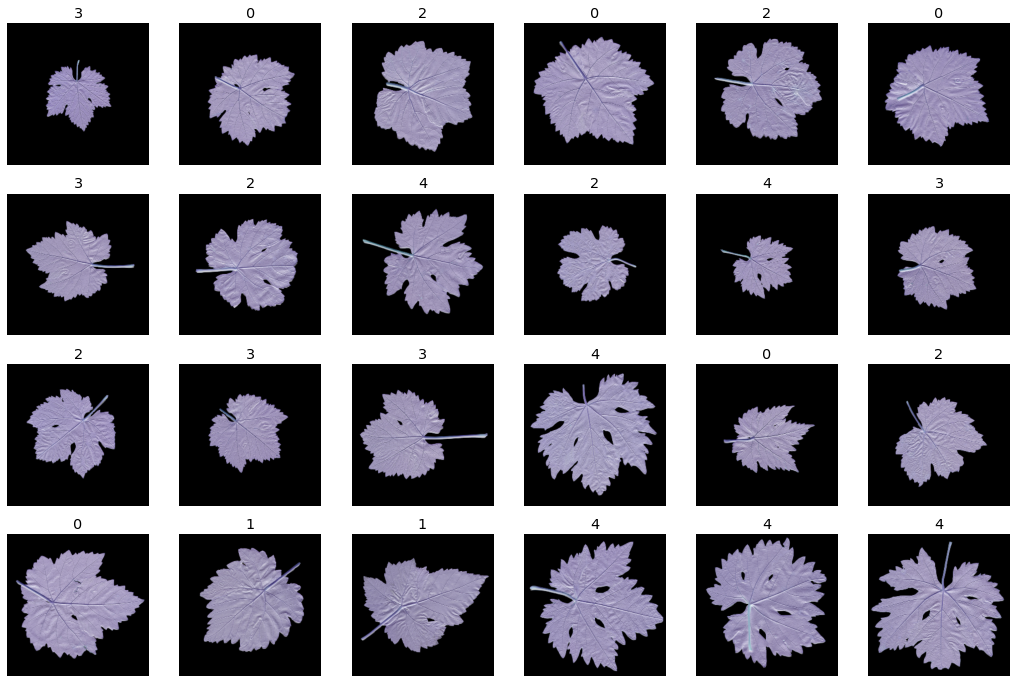

In [ ]:
plt.figure(figsize=(18, 12))
for images, labels in augmented_train_data.take(1):
    for i in range(24):
        ax = plt.subplot(4, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Pre-Trained Models

### Training Parameters


In [ ]:
pre_trained_data = train_data2
pre_trained_epochs = 30
pre_trained_validation_data = validation_data2

### Xception

#### Model Architecture Define

In [ ]:
pretrained_model = tf.keras.applications.Xception(
        weights='imagenet',
        include_top=False ,
        input_shape=image_size + (3,))
pretrained_model.trainable = False
Xception_Model = tf.keras.Sequential([
    layers.RandomRotation(0.3, fill_mode='constant', fill_value=0, input_shape=image_size + (3,)),
    layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    pretrained_model, layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')])
Xception_Model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_2 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_4 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_5 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            

#### Model Creation and Training

In [ ]:
Xception_Model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
Xception_Model_History = Xception_Model.fit(
    pre_trained_data,
    epochs = pre_trained_epochs,
    validation_data = pre_trained_validation_data)

#### Accuracy and Loss Curves

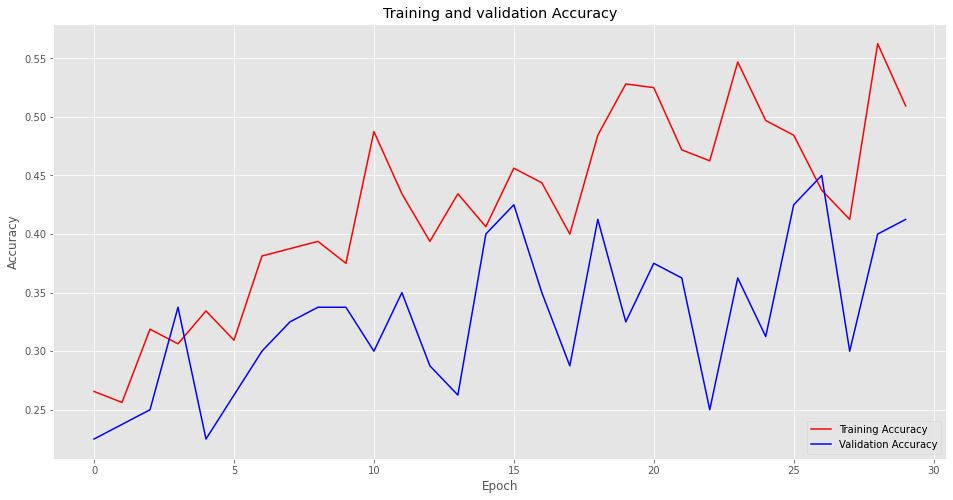

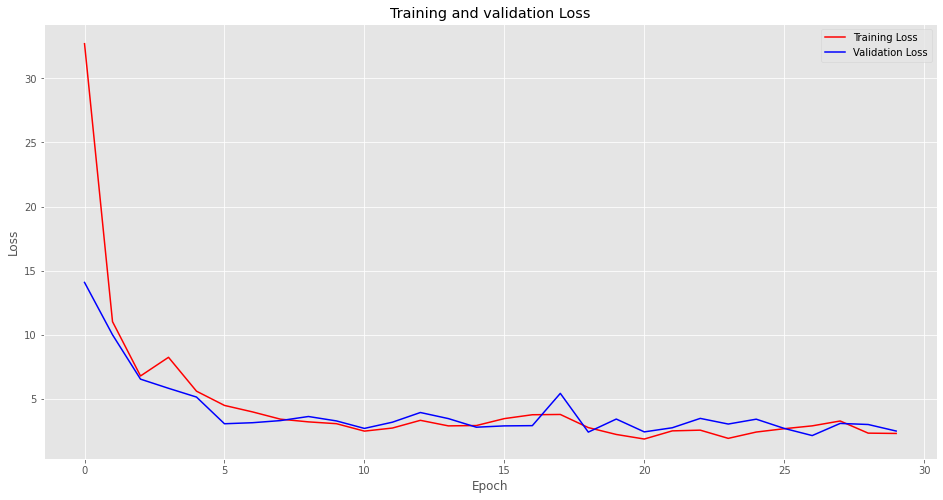

In [ ]:
Xception_Model_acc = Xception_Model_History.history['accuracy']
Xception_Model_val_acc = Xception_Model_History.history['val_accuracy']
Xception_Model_loss = Xception_Model_History.history['loss']
Xception_Model_val_loss = Xception_Model_History.history['val_loss']
epochs = range(len(Xception_Model_acc))
fig = plt.figure(figsize=(16,8))
plt.plot(epochs, Xception_Model_acc, 'r', label="Training Accuracy")
plt.plot(epochs, Xception_Model_val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc='lower right')
fig2 = plt.figure(figsize=(16,8))
plt.plot(epochs, Xception_Model_loss, 'r', label="Training Loss")
plt.plot(epochs, Xception_Model_val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.show()

#### Model Performance Evaluation on Test Data 

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

result = Xception_Model.predict(test_data2)
Xception_Model_y_predict = np.array([i.argmax() for i in result])

Xception_Model_cm = confusion_matrix(y_test, Xception_Model_y_predict)
Xception_Model_ac = accuracy_score(y_test,Xception_Model_y_predict)

print("confusion matrix on test data :\n",Xception_Model_cm)
print("accuracy score on test data:\n",Xception_Model_ac)

print(classification_report(y_test, Xception_Model_y_predict))

confusion matrix on test data :
 [[ 6  2  4  4  4]
 [ 1  7  1  4  7]
 [ 0  3 10  1  6]
 [ 0  1  4  8  7]
 [ 1  0  1  3 15]]
accuracy score on test data:
 0.46
              precision    recall  f1-score   support

           0       0.75      0.30      0.43        20
           1       0.54      0.35      0.42        20
           2       0.50      0.50      0.50        20
           3       0.40      0.40      0.40        20
           4       0.38      0.75      0.51        20

    accuracy                           0.46       100
   macro avg       0.51      0.46      0.45       100
weighted avg       0.51      0.46      0.45       100



### VGG16

#### Model Architecture Define

In [ ]:
pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=image_size + (3,),
    classes=1000,
    classifier_activation="softmax",
)
pretrained_model.trainable = False
VGG16_Model = tf.keras.Sequential([
    layers.RandomRotation(0.3, fill_mode='constant', fill_value=0, input_shape=image_size + (3,)),
    layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    pretrained_model, layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')])
VGG16_Model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_3 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_6 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_7 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             

#### Model Creation and Training

In [ ]:
VGG16_Model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
VGG16_Model_History = VGG16_Model.fit(
    pre_trained_data,
    epochs = pre_trained_epochs,
    validation_data = pre_trained_validation_data)

#### Accuracy and Loss Curves

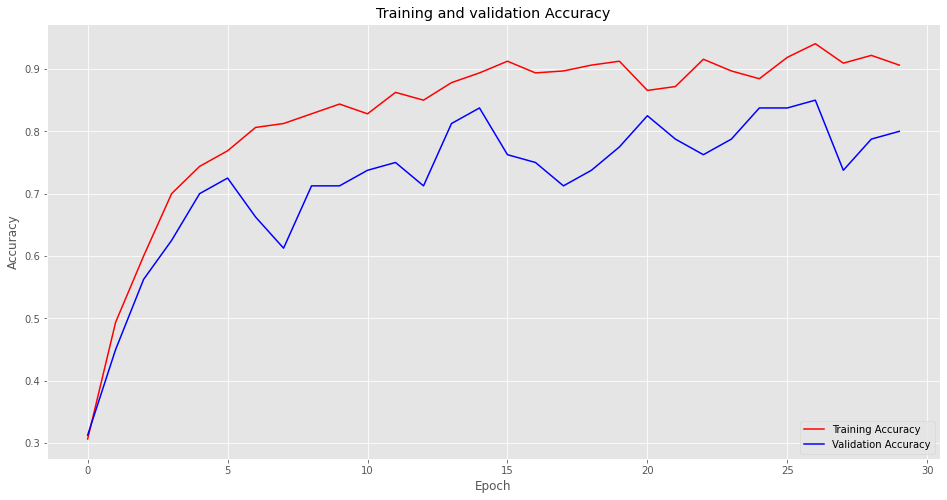

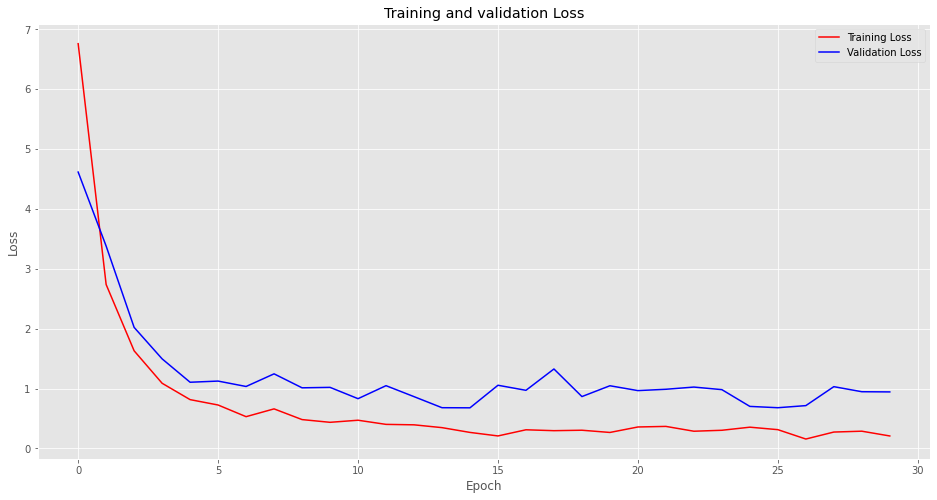

In [ ]:
VGG16_Model_acc = VGG16_Model_History.history['accuracy']
VGG16_Model_val_acc = VGG16_Model_History.history['val_accuracy']
VGG16_Model_loss = VGG16_Model_History.history['loss']
VGG16_Model_val_loss = VGG16_Model_History.history['val_loss']
epochs = range(len(VGG16_Model_acc))
fig = plt.figure(figsize=(16,8))
plt.plot(epochs, VGG16_Model_acc, 'r', label="Training Accuracy")
plt.plot(epochs, VGG16_Model_val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc='lower right')
fig2 = plt.figure(figsize=(16,8))
plt.plot(epochs, VGG16_Model_loss, 'r', label="Training Loss")
plt.plot(epochs, VGG16_Model_val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.show()

#### Model Performance Evaluation on Test Data 

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

result = VGG16_Model.predict(test_data2)
VGG16_Model_y_predict = np.array([i.argmax() for i in result])

VGG16_Model_cm = confusion_matrix(y_test, VGG16_Model_y_predict)
VGG16_Model_ac = accuracy_score(y_test,VGG16_Model_y_predict)

print("confusion matrix on test data :\n",VGG16_Model_cm)
print("accuracy score on test data:\n",VGG16_Model_ac)

print(classification_report(y_test, VGG16_Model_y_predict))

confusion matrix on test data :
 [[15  5  0  0  0]
 [ 0 17  2  0  1]
 [ 0  2 17  1  0]
 [ 2  0  2 16  0]
 [ 1  0  0  0 19]]
accuracy score on test data:
 0.84
              precision    recall  f1-score   support

           0       0.83      0.75      0.79        20
           1       0.71      0.85      0.77        20
           2       0.81      0.85      0.83        20
           3       0.94      0.80      0.86        20
           4       0.95      0.95      0.95        20

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



### VGG19

#### Model Architecture Define

In [ ]:
pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=image_size + (3,),
    classes=1000,
    classifier_activation="softmax",
)
pretrained_model.trainable = False
VGG19_Model = tf.keras.Sequential([
    layers.RandomRotation(0.3, fill_mode='constant', fill_value=0, input_shape=image_size + (3,)),
    layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    pretrained_model, layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')])
VGG19_Model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_4 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_8 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_9 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                      

#### Model Creation and Training

In [ ]:
VGG19_Model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
VGG19_Model_History = VGG19_Model.fit(
    pre_trained_data,
    epochs = pre_trained_epochs,
    validation_data = pre_trained_validation_data)

#### Accuracy and Loss Curves

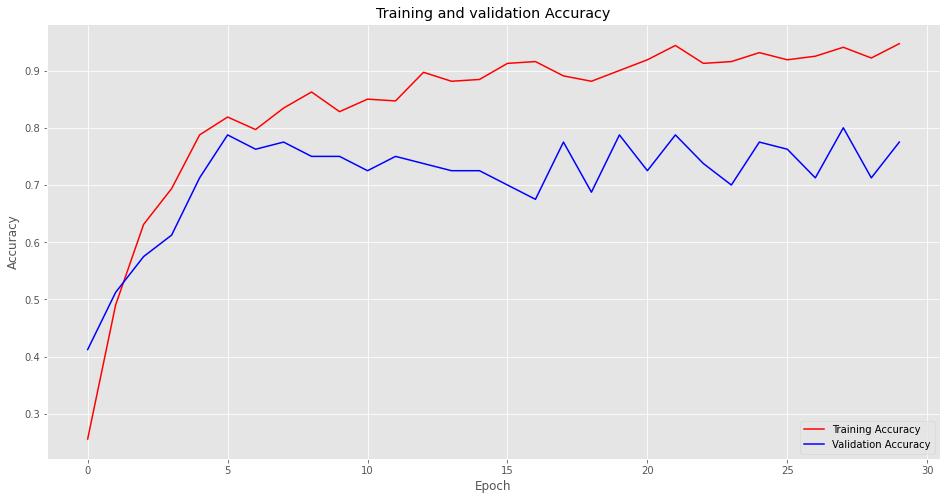

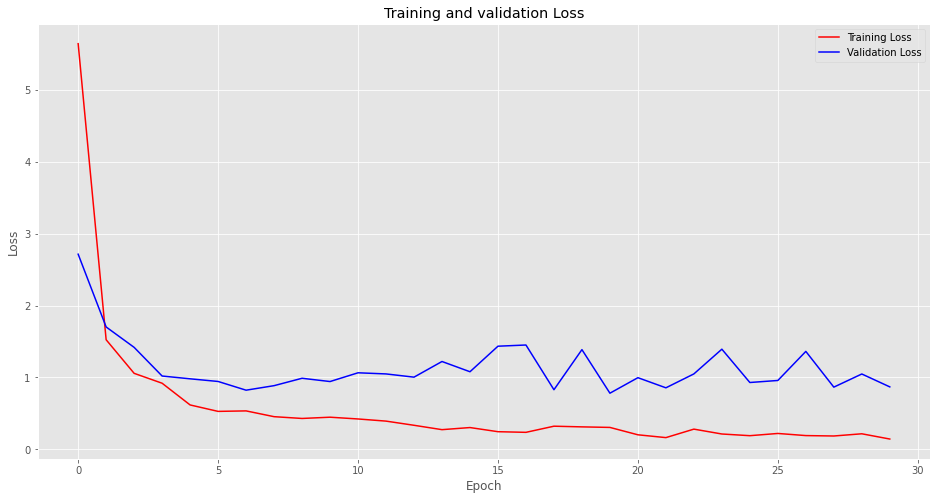

In [ ]:
VGG19_Model_acc = VGG19_Model_History.history['accuracy']
VGG19_Model_val_acc = VGG19_Model_History.history['val_accuracy']
VGG19_Model_loss = VGG19_Model_History.history['loss']
VGG19_Model_val_loss = VGG19_Model_History.history['val_loss']
epochs = range(len(VGG19_Model_acc))
fig = plt.figure(figsize=(16,8))
plt.plot(epochs, VGG19_Model_acc, 'r', label="Training Accuracy")
plt.plot(epochs, VGG19_Model_val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc='lower right')
fig2 = plt.figure(figsize=(16,8))
plt.plot(epochs, VGG19_Model_loss, 'r', label="Training Loss")
plt.plot(epochs, VGG19_Model_val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.show()

#### Model Performance Evaluation on Test Data 

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

result = VGG19_Model.predict(test_data2)
VGG19_Model_y_predict = np.array([i.argmax() for i in result])

VGG19_Model_cm = confusion_matrix(y_test, VGG19_Model_y_predict)
VGG19_Model_ac = accuracy_score(y_test,VGG19_Model_y_predict)

print("confusion matrix on test data :\n",VGG19_Model_cm)
print("accuracy score on test data:\n",VGG19_Model_ac)

print(classification_report(y_test, VGG19_Model_y_predict))

confusion matrix on test data :
 [[17  3  0  0  0]
 [ 1 16  3  0  0]
 [ 0  2 18  0  0]
 [ 2  0  3 15  0]
 [ 2  1  2  0 15]]
accuracy score on test data:
 0.81
              precision    recall  f1-score   support

           0       0.77      0.85      0.81        20
           1       0.73      0.80      0.76        20
           2       0.69      0.90      0.78        20
           3       1.00      0.75      0.86        20
           4       1.00      0.75      0.86        20

    accuracy                           0.81       100
   macro avg       0.84      0.81      0.81       100
weighted avg       0.84      0.81      0.81       100



### ResNet50

#### Model Architecture Define

In [ ]:
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=image_size + (3,),
    classes=1000,
)
pretrained_model.trainable = False
ResNet50_Model = tf.keras.Sequential([
    layers.RandomRotation(0.3, fill_mode='constant', fill_value=0, input_shape=image_size + (3,)),
    layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    pretrained_model, layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')])
ResNet50_Model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_5 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_4 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_10 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 random_flip_11 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 131072)            

#### Model Creation and Training

In [ ]:
ResNet50_Model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
ResNet50_Model_History = ResNet50_Model.fit(
    pre_trained_data,
    epochs = pre_trained_epochs,
    validation_data = pre_trained_validation_data)

#### Accuracy and Loss Curves

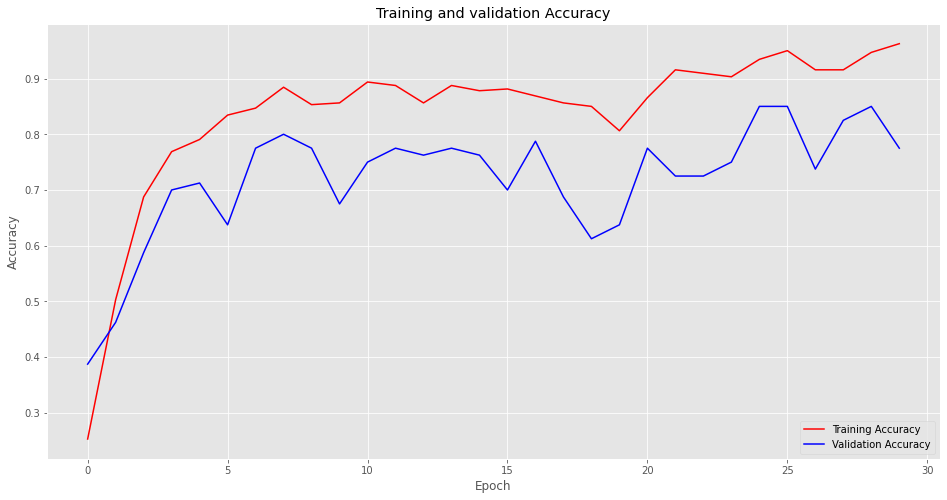

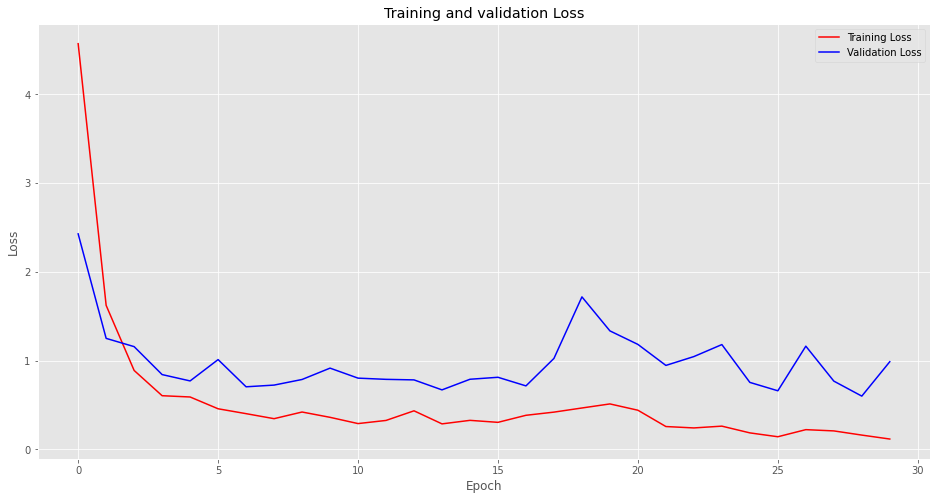

In [ ]:
ResNet50_Model_acc = ResNet50_Model_History.history['accuracy']
ResNet50_Model_val_acc = ResNet50_Model_History.history['val_accuracy']
ResNet50_Model_loss = ResNet50_Model_History.history['loss']
ResNet50_Model_val_loss = ResNet50_Model_History.history['val_loss']
epochs = range(len(ResNet50_Model_acc))
fig = plt.figure(figsize=(16,8))
plt.plot(epochs, ResNet50_Model_acc, 'r', label="Training Accuracy")
plt.plot(epochs, ResNet50_Model_val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc='lower right')
fig2 = plt.figure(figsize=(16,8))
plt.plot(epochs, ResNet50_Model_loss, 'r', label="Training Loss")
plt.plot(epochs, ResNet50_Model_val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.show()

#### Model Performance Evaluation on Test Data 

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

result = ResNet50_Model.predict(test_data2)
ResNet50_Model_y_predict = np.array([i.argmax() for i in result])

ResNet50_Model_cm = confusion_matrix(y_test, ResNet50_Model_y_predict)
ResNet50_Model_ac = accuracy_score(y_test,ResNet50_Model_y_predict)

print("confusion matrix on test data :\n",ResNet50_Model_cm)
print("accuracy score on test data:\n",ResNet50_Model_ac)

print(classification_report(y_test, ResNet50_Model_y_predict))

confusion matrix on test data :
 [[18  0  1  0  1]
 [ 4 13  2  0  1]
 [ 2  0 17  1  0]
 [ 2  0  1 14  3]
 [ 1  0  0  0 19]]
accuracy score on test data:
 0.81
              precision    recall  f1-score   support

           0       0.67      0.90      0.77        20
           1       1.00      0.65      0.79        20
           2       0.81      0.85      0.83        20
           3       0.93      0.70      0.80        20
           4       0.79      0.95      0.86        20

    accuracy                           0.81       100
   macro avg       0.84      0.81      0.81       100
weighted avg       0.84      0.81      0.81       100



### ResNet101

#### Model Architecture Define

In [ ]:
pretrained_model = tf.keras.applications.ResNet101(
    include_top=False,
    weights="imagenet",
    input_shape=image_size + (3,),
    classes=1000,
)
pretrained_model.trainable = False
ResNet101_Model = tf.keras.Sequential([
    layers.RandomRotation(0.3, fill_mode='constant', fill_value=0, input_shape=image_size + (3,)),
    layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    pretrained_model, layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')])
ResNet101_Model.summary()

171458560/171446536 [==============================] - 1s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_6 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_5 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_12 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 random_flip_13 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 resnet101 (Functional)      (None, 8, 8, 2048)        42658176  
                                                                 
 flatten_5 (Flatten)         (None, 131072)          

#### Model Creation and Training

In [ ]:
ResNet101_Model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
ResNet101_Model_History = ResNet101_Model.fit(
    pre_trained_data,
    epochs = pre_trained_epochs,
    validation_data = pre_trained_validation_data)

#### Accuracy and Loss Curves

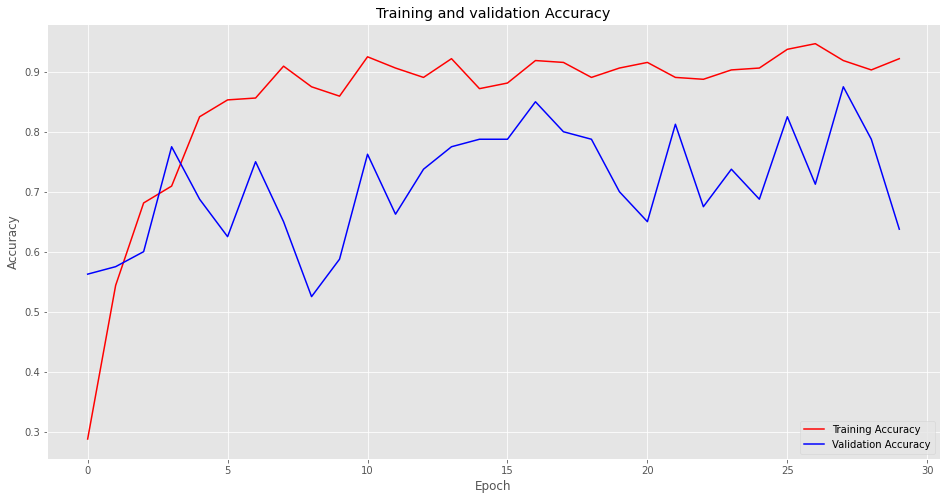

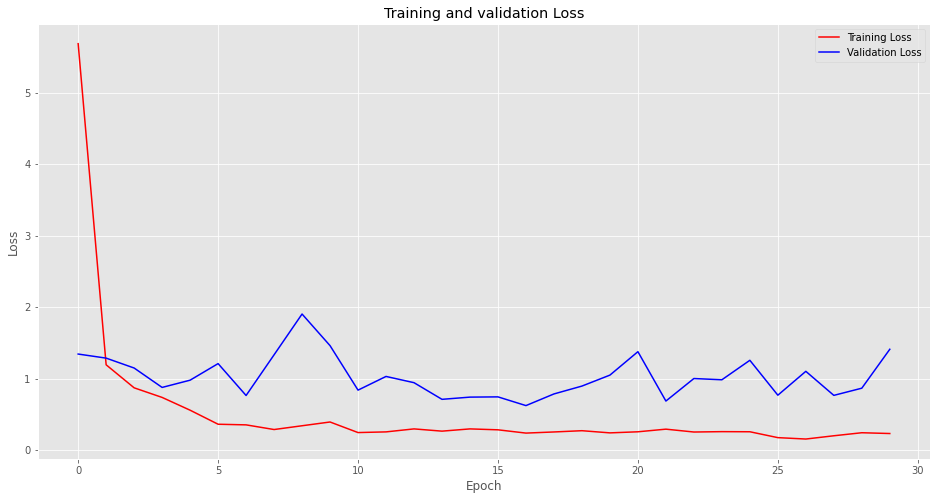

In [ ]:
ResNet101_Model_acc = ResNet101_Model_History.history['accuracy']
ResNet101_Model_val_acc = ResNet101_Model_History.history['val_accuracy']
ResNet101_Model_loss = ResNet101_Model_History.history['loss']
ResNet101_Model_val_loss = ResNet101_Model_History.history['val_loss']
epochs = range(len(ResNet101_Model_acc))
fig = plt.figure(figsize=(16,8))
plt.plot(epochs, ResNet101_Model_acc, 'r', label="Training Accuracy")
plt.plot(epochs, ResNet101_Model_val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc='lower right')
fig2 = plt.figure(figsize=(16,8))
plt.plot(epochs, ResNet101_Model_loss, 'r', label="Training Loss")
plt.plot(epochs, ResNet101_Model_val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.show()

#### Model Performance Evaluation on Test Data 

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

result = ResNet101_Model.predict(test_data2)
ResNet101_Model_y_predict = np.array([i.argmax() for i in result])

ResNet101_Model_cm = confusion_matrix(y_test, ResNet101_Model_y_predict)
ResNet101_Model_ac = accuracy_score(y_test,ResNet101_Model_y_predict)

print("confusion matrix on test data :\n",ResNet101_Model_cm)
print("accuracy score on test data:\n",ResNet101_Model_ac)

print(classification_report(y_test, ResNet101_Model_y_predict))

confusion matrix on test data :
 [[18  0  0  0  2]
 [ 1 11  3  0  5]
 [ 3  1 14  0  2]
 [ 5  0  0  8  7]
 [ 0  0  0  0 20]]
accuracy score on test data:
 0.71
              precision    recall  f1-score   support

           0       0.67      0.90      0.77        20
           1       0.92      0.55      0.69        20
           2       0.82      0.70      0.76        20
           3       1.00      0.40      0.57        20
           4       0.56      1.00      0.71        20

    accuracy                           0.71       100
   macro avg       0.79      0.71      0.70       100
weighted avg       0.79      0.71      0.70       100



### ResNet152

#### Model Architecture Define

In [ ]:
pretrained_model = tf.keras.applications.ResNet152(
    include_top=False,
    weights="imagenet",
    input_shape=image_size + (3,),
    classes=1000,
)
pretrained_model.trainable = False
ResNet152_Model = tf.keras.Sequential([
    layers.RandomRotation(0.3, fill_mode='constant', fill_value=0, input_shape=image_size + (3,)),
    layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    pretrained_model, layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')])
ResNet152_Model.summary()

234708992/234698864 [==============================] - 1s 0us/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_7 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_6 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_14 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 random_flip_15 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 8, 8, 2048)        58370944  
                                                                 
 flatten_6 (Flatten)         (None, 131072)          

#### Model Creation and Training

In [ ]:
ResNet152_Model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
ResNet152_Model_History = ResNet152_Model.fit(
    pre_trained_data,
    epochs = pre_trained_epochs,
    validation_data = pre_trained_validation_data)

#### Accuracy and Loss Curves

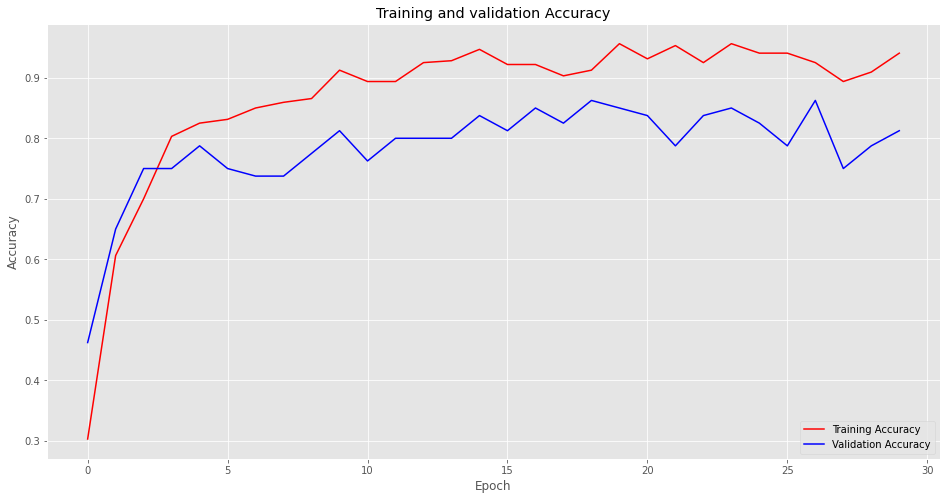

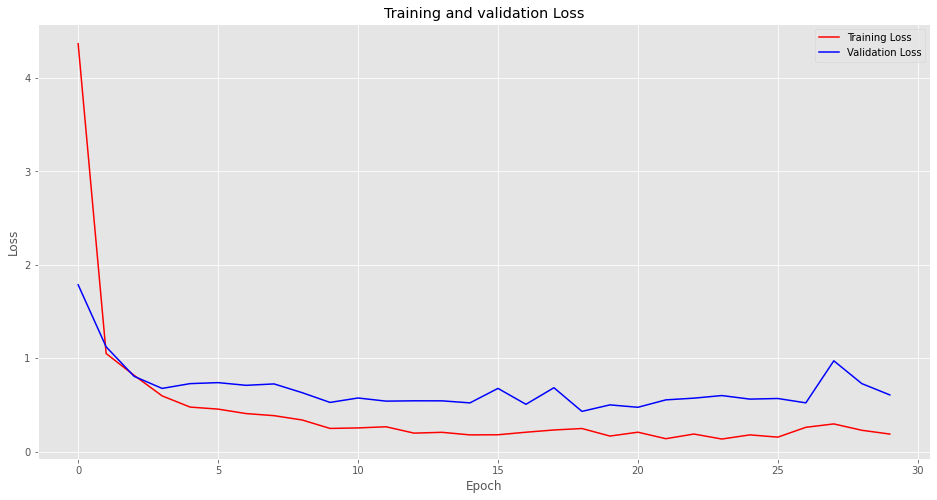

In [ ]:
ResNet152_Model_acc = ResNet152_Model_History.history['accuracy']
ResNet152_Model_val_acc = ResNet152_Model_History.history['val_accuracy']
ResNet152_Model_loss = ResNet152_Model_History.history['loss']
ResNet152_Model_val_loss = ResNet152_Model_History.history['val_loss']
epochs = range(len(ResNet152_Model_acc))
fig = plt.figure(figsize=(16,8))
plt.plot(epochs, ResNet152_Model_acc, 'r', label="Training Accuracy")
plt.plot(epochs, ResNet152_Model_val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc='lower right')
fig2 = plt.figure(figsize=(16,8))
plt.plot(epochs, ResNet152_Model_loss, 'r', label="Training Loss")
plt.plot(epochs, ResNet152_Model_val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.show()

#### Model Performance Evaluation on Test Data 

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

result = ResNet152_Model.predict(test_data2)
ResNet152_Model_y_predict = np.array([i.argmax() for i in result])

ResNet152_Model_cm = confusion_matrix(y_test, ResNet152_Model_y_predict)
ResNet152_Model_ac = accuracy_score(y_test,ResNet152_Model_y_predict)

print("confusion matrix on test data :\n",ResNet152_Model_cm)
print("accuracy score on test data:\n",ResNet152_Model_ac)

print(classification_report(y_test, ResNet152_Model_y_predict))

confusion matrix on test data :
 [[17  1  1  1  0]
 [ 2 16  0  0  2]
 [ 1  2 15  0  2]
 [ 0  0  1 17  2]
 [ 0  0  1  0 19]]
accuracy score on test data:
 0.84
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        20
           1       0.84      0.80      0.82        20
           2       0.83      0.75      0.79        20
           3       0.94      0.85      0.89        20
           4       0.76      0.95      0.84        20

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



### InceptionV3

#### Model Architecture Define

In [ ]:
pretrained_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=image_size + (3,),
    classes=1000,
    classifier_activation="softmax",
)
pretrained_model.trainable = False
InceptionV3_Model = tf.keras.Sequential([
    layers.RandomRotation(0.3, fill_mode='constant', fill_value=0, input_shape=image_size + (3,)),
    layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    pretrained_model, layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')])
InceptionV3_Model.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_8 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_7 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_16 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 random_flip_17 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_7 (Flatten)         (None, 73728)             

#### Model Creation and Training

In [ ]:
InceptionV3_Model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
InceptionV3_Model_History = InceptionV3_Model.fit(
    pre_trained_data,
    epochs = pre_trained_epochs,
    validation_data = pre_trained_validation_data)

#### Accuracy and Loss Curves

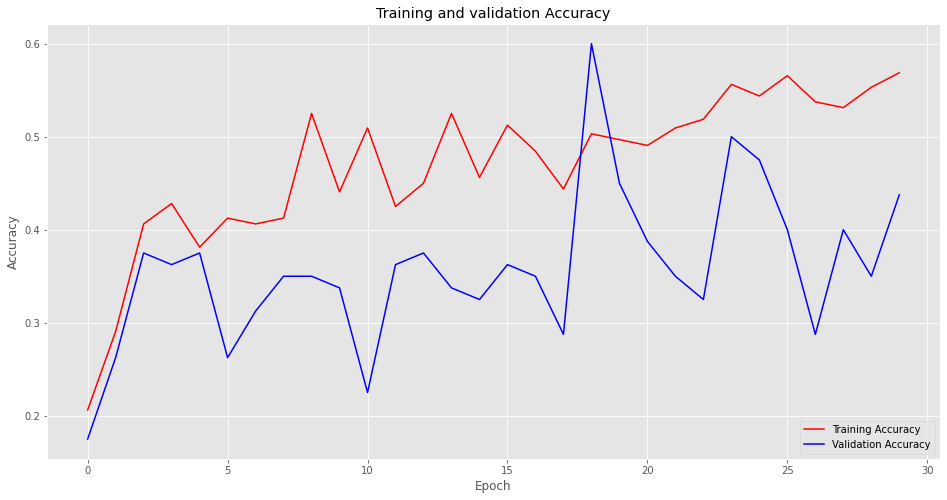

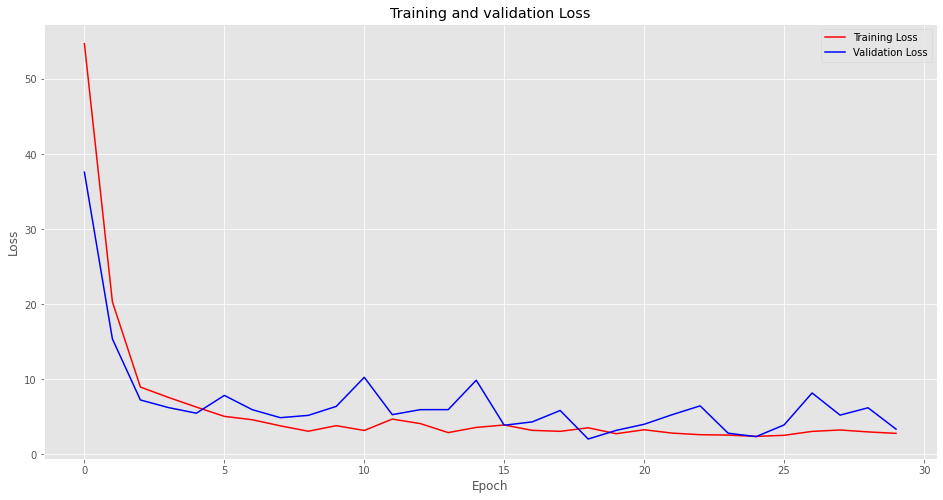

In [ ]:
InceptionV3_Model_acc = InceptionV3_Model_History.history['accuracy']
InceptionV3_Model_val_acc = InceptionV3_Model_History.history['val_accuracy']
InceptionV3_Model_loss = InceptionV3_Model_History.history['loss']
InceptionV3_Model_val_loss = InceptionV3_Model_History.history['val_loss']
epochs = range(len(InceptionV3_Model_acc))
fig = plt.figure(figsize=(16,8))
plt.plot(epochs, InceptionV3_Model_acc, 'r', label="Training Accuracy")
plt.plot(epochs, InceptionV3_Model_val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc='lower right')
fig2 = plt.figure(figsize=(16,8))
plt.plot(epochs, InceptionV3_Model_loss, 'r', label="Training Loss")
plt.plot(epochs, InceptionV3_Model_val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.show()

#### Model Performance Evaluation on Test Data 

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

result = InceptionV3_Model.predict(test_data2)
InceptionV3_Model_y_predict = np.array([i.argmax() for i in result])

InceptionV3_Model_cm = confusion_matrix(y_test, InceptionV3_Model_y_predict)
InceptionV3_Model_ac = accuracy_score(y_test,InceptionV3_Model_y_predict)

print("confusion matrix on test data :\n",InceptionV3_Model_cm)
print("accuracy score on test data:\n",InceptionV3_Model_ac)

print(classification_report(y_test, InceptionV3_Model_y_predict))

confusion matrix on test data :
 [[ 0  5  3 11  1]
 [ 0  6  2  8  4]
 [ 0  1  6  9  4]
 [ 0  2  0 14  4]
 [ 0  1  0  6 13]]
accuracy score on test data:
 0.39
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.40      0.30      0.34        20
           2       0.55      0.30      0.39        20
           3       0.29      0.70      0.41        20
           4       0.50      0.65      0.57        20

    accuracy                           0.39       100
   macro avg       0.35      0.39      0.34       100
weighted avg       0.35      0.39      0.34       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### InceptionResNetV2

#### Model Architecture Define

In [ ]:
pretrained_model = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=image_size + (3,),
    classes=1000,
    classifier_activation="softmax",
)
pretrained_model.trainable = False
InceptionResNetV2_Model = tf.keras.Sequential([
    layers.RandomRotation(0.3, fill_mode='constant', fill_value=0, input_shape=image_size + (3,)),
    layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    pretrained_model, layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')])
InceptionResNetV2_Model.summary()

219070464/219055592 [==============================] - 1s 0us/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_9 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_8 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 random_flip_18 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 random_flip_19 (RandomFlip)  (None, 256, 256, 3)      0         
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                     

#### Model Creation and Training

In [ ]:
InceptionResNetV2_Model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
InceptionResNetV2_Model_History = InceptionResNetV2_Model.fit(
    pre_trained_data,
    epochs = pre_trained_epochs,
    validation_data = pre_trained_validation_data)

#### Accuracy and Loss Curves

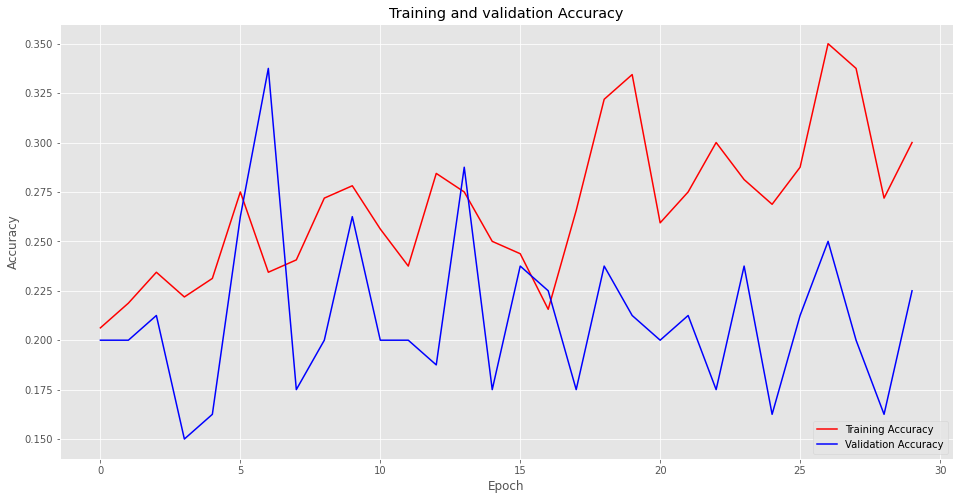

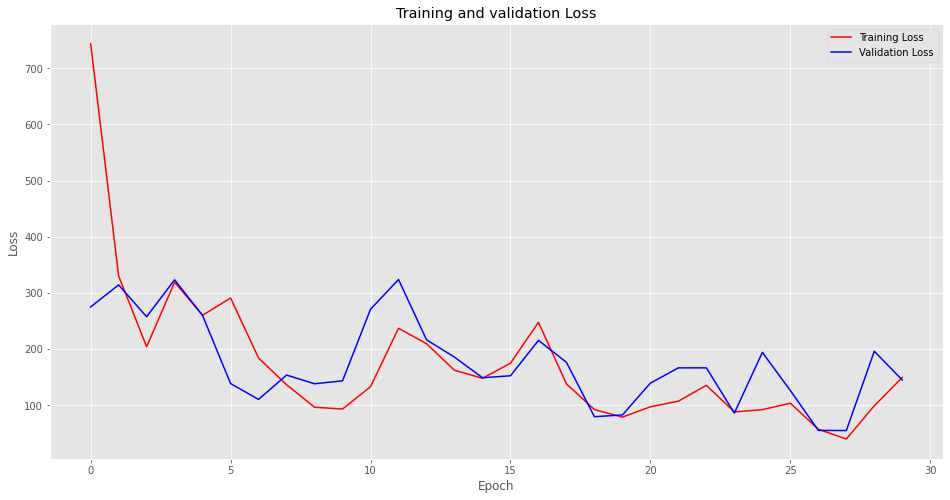

In [ ]:
InceptionResNetV2_Model_acc = InceptionResNetV2_Model_History.history['accuracy']
InceptionResNetV2_Model_val_acc = InceptionResNetV2_Model_History.history['val_accuracy']
InceptionResNetV2_Model_loss = InceptionResNetV2_Model_History.history['loss']
InceptionResNetV2_Model_val_loss = InceptionResNetV2_Model_History.history['val_loss']
epochs = range(len(InceptionResNetV2_Model_acc))
fig = plt.figure(figsize=(16,8))
plt.plot(epochs, InceptionResNetV2_Model_acc, 'r', label="Training Accuracy")
plt.plot(epochs, InceptionResNetV2_Model_val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc='lower right')
fig2 = plt.figure(figsize=(16,8))
plt.plot(epochs, InceptionResNetV2_Model_loss, 'r', label="Training Loss")
plt.plot(epochs, InceptionResNetV2_Model_val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation Loss')
plt.show()

#### Model Performance Evaluation on Test Data

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

result = InceptionResNetV2_Model.predict(test_data2)
InceptionResNetV2_Model_y_predict = np.array([i.argmax() for i in result])

InceptionResNetV2_Model_cm = confusion_matrix(y_test, InceptionResNetV2_Model_y_predict)
InceptionResNetV2_Model_ac = accuracy_score(y_test,InceptionResNetV2_Model_y_predict)

print("confusion matrix on test data :\n",InceptionResNetV2_Model_cm)
print("accuracy score on test data:\n",InceptionResNetV2_Model_ac)

print(classification_report(y_test, InceptionResNetV2_Model_y_predict))

confusion matrix on test data :
 [[ 0  1 16  3  0]
 [ 0  0 17  3  0]
 [ 0  1 18  1  0]
 [ 0  0 19  1  0]
 [ 0  3 14  3  0]]
accuracy score on test data:
 0.19
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.00      0.00      0.00        20
           2       0.21      0.90      0.35        20
           3       0.09      0.05      0.06        20
           4       0.00      0.00      0.00        20

    accuracy                           0.19       100
   macro avg       0.06      0.19      0.08       100
weighted avg       0.06      0.19      0.08       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Comparing Pre-Trained Models

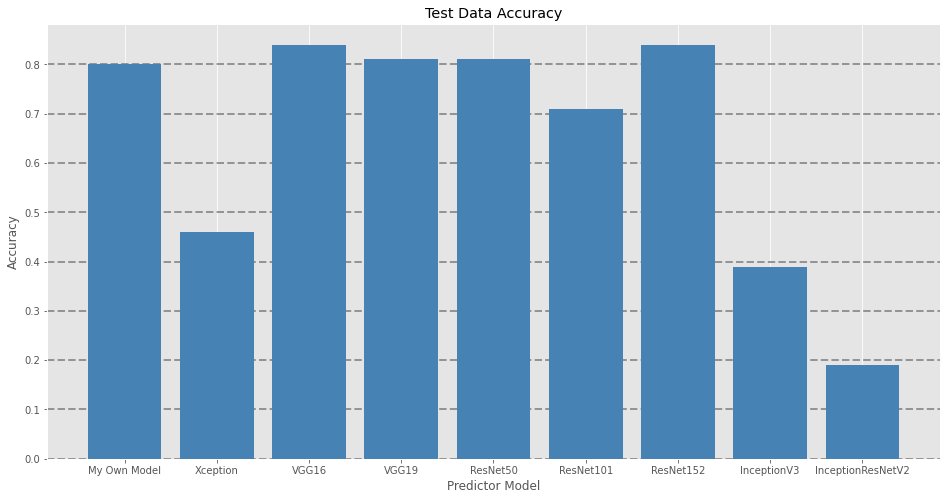

In [ ]:
Models_Names = ["My Own Model", "Xception", "VGG16", "VGG19",
                "ResNet50", "ResNet101", "ResNet152",
                "InceptionV3", "InceptionResNetV2"]
Models_test_acc = [MyOwnModel_ac, Xception_Model_ac, VGG16_Model_ac, VGG19_Model_ac,
                   ResNet50_Model_ac, ResNet101_Model_ac, ResNet152_Model_ac,
                   InceptionV3_Model_ac, InceptionResNetV2_Model_ac]

fig = plt.figure(figsize=(16,8))
plt.bar(Models_Names, Models_test_acc, color='steelblue')
plt.grid(color='gray', linestyle='--', linewidth=2, axis='y', alpha=0.8)
plt.xlabel('Predictor Model')
plt.ylabel('Accuracy')
plt.title('Test Data Accuracy')
plt.show()

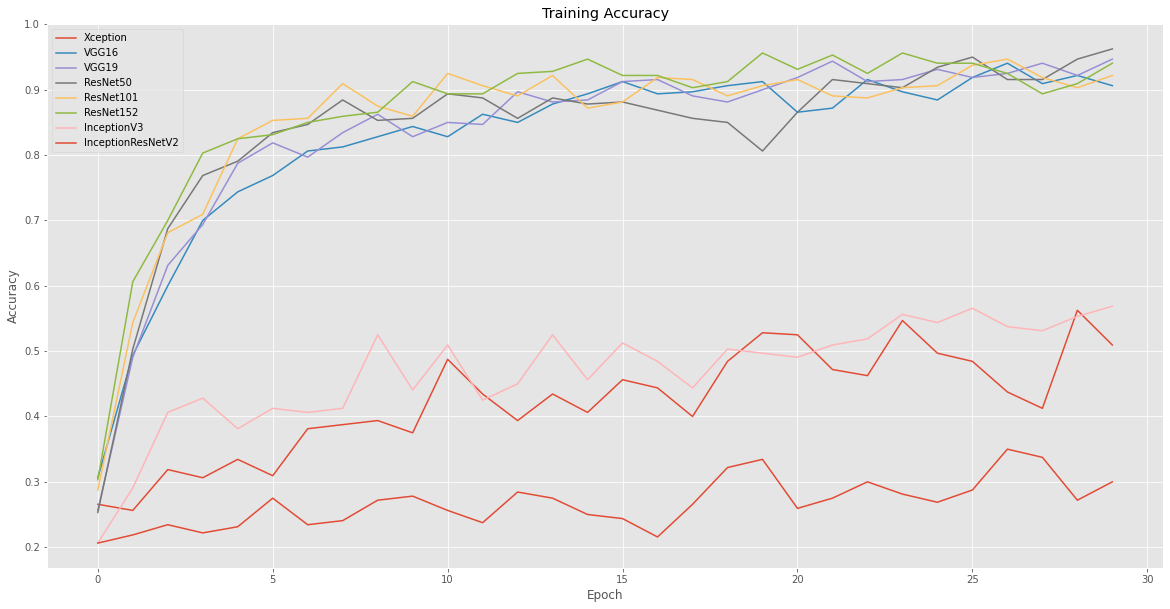

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, Xception_Model_acc, label="Xception")
plt.plot(epochs, VGG16_Model_acc, label="VGG16")
plt.plot(epochs, VGG19_Model_acc, label="VGG19")
plt.plot(epochs, ResNet50_Model_acc, label="ResNet50")
plt.plot(epochs, ResNet101_Model_acc, label="ResNet101")
plt.plot(epochs, ResNet152_Model_acc, label="ResNet152")
plt.plot(epochs, InceptionV3_Model_acc, label="InceptionV3")
plt.plot(epochs, InceptionResNetV2_Model_acc, label="InceptionResNetV2")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend(loc='upper left')
plt.show()

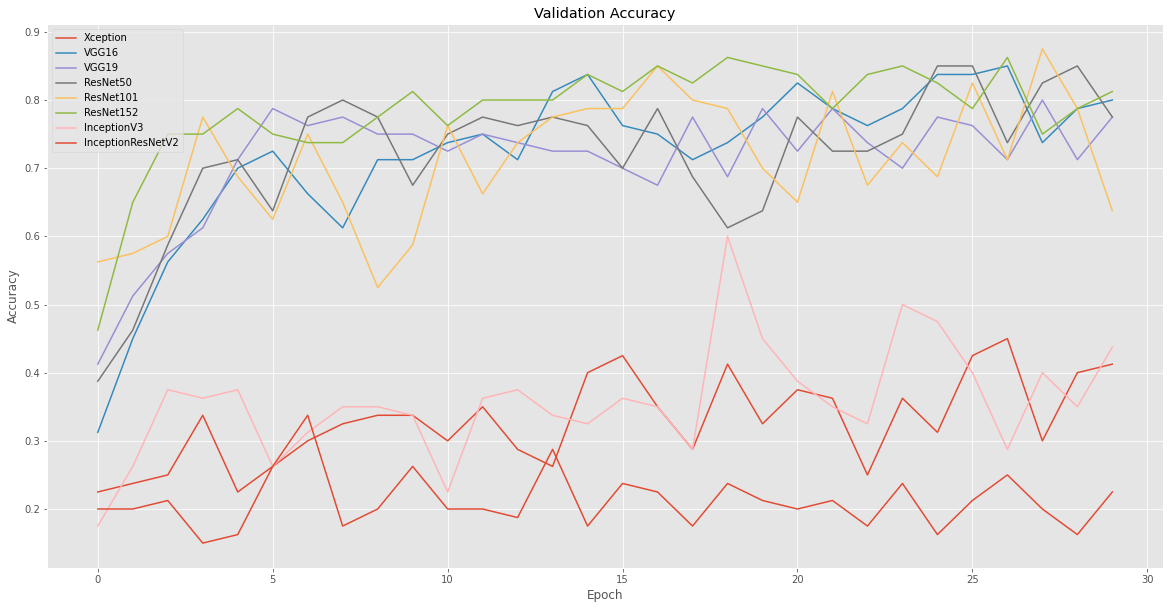

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, Xception_Model_val_acc, label="Xception")
plt.plot(epochs, VGG16_Model_val_acc, label="VGG16")
plt.plot(epochs, VGG19_Model_val_acc, label="VGG19")
plt.plot(epochs, ResNet50_Model_val_acc, label="ResNet50")
plt.plot(epochs, ResNet101_Model_val_acc, label="ResNet101")
plt.plot(epochs, ResNet152_Model_val_acc, label="ResNet152")
plt.plot(epochs, InceptionV3_Model_val_acc, label="InceptionV3")
plt.plot(epochs, InceptionResNetV2_Model_val_acc, label="InceptionResNetV2")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend(loc='upper left')
plt.show()

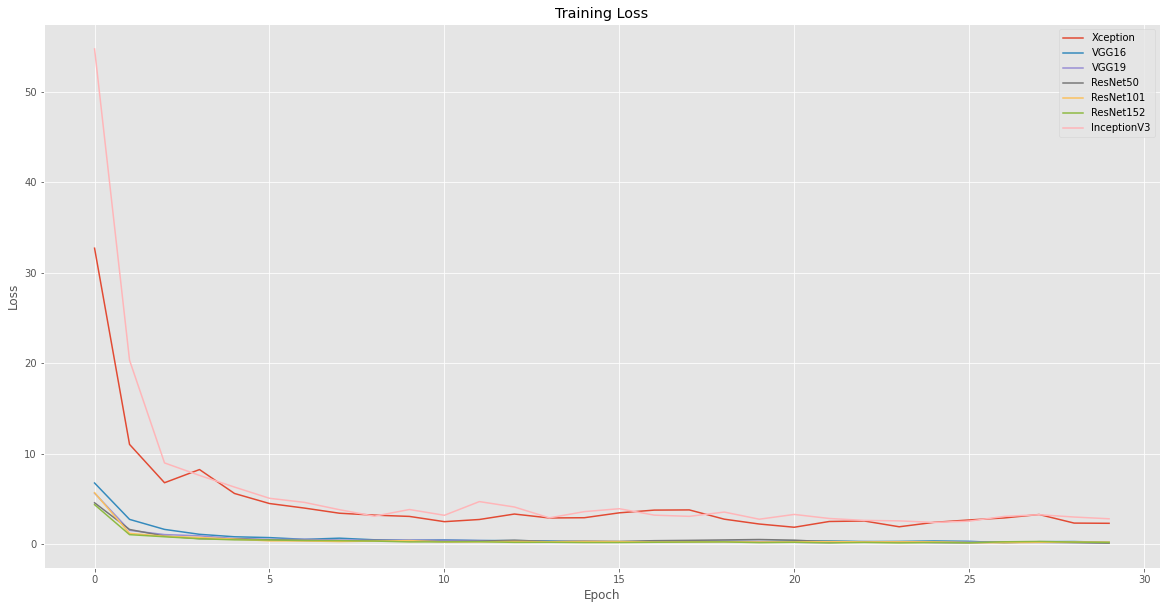

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, Xception_Model_loss, label="Xception")
plt.plot(epochs, VGG16_Model_loss, label="VGG16")
plt.plot(epochs, VGG19_Model_loss, label="VGG19")
plt.plot(epochs, ResNet50_Model_loss, label="ResNet50")
plt.plot(epochs, ResNet101_Model_loss, label="ResNet101")
plt.plot(epochs, ResNet152_Model_loss, label="ResNet152")
plt.plot(epochs, InceptionV3_Model_loss, label="InceptionV3")
#plt.plot(epochs, InceptionResNetV2_Model_loss, label="InceptionResNetV2")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend(loc='upper right')
plt.show()

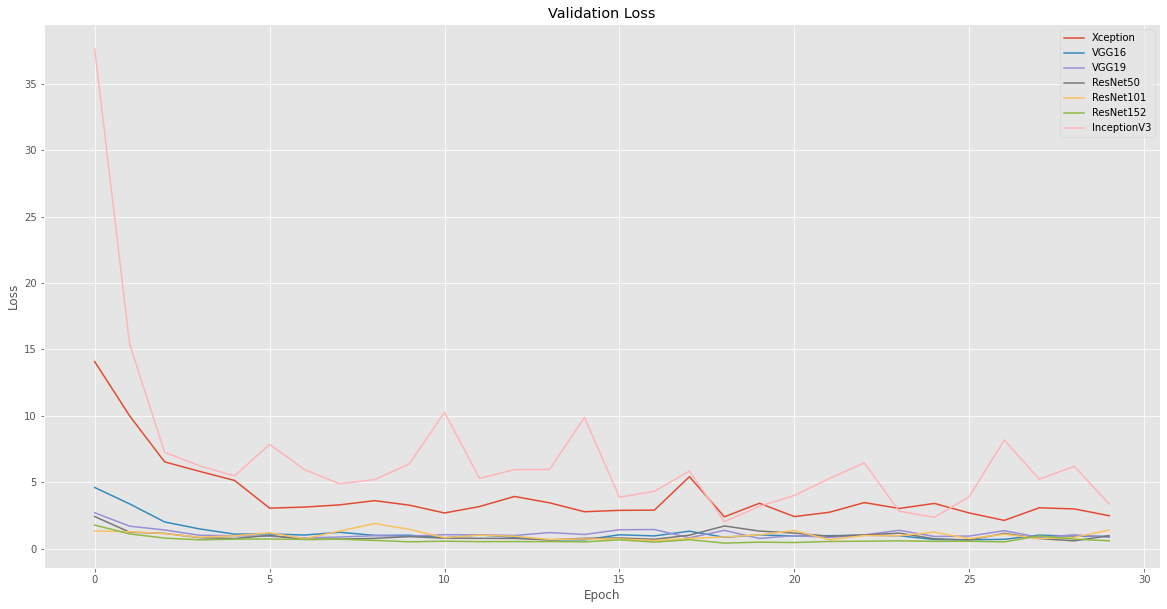

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, Xception_Model_val_loss, label="Xception")
plt.plot(epochs, VGG16_Model_val_loss, label="VGG16")
plt.plot(epochs, VGG19_Model_val_loss, label="VGG19")
plt.plot(epochs, ResNet50_Model_val_loss, label="ResNet50")
plt.plot(epochs, ResNet101_Model_val_loss, label="ResNet101")
plt.plot(epochs, ResNet152_Model_val_loss, label="ResNet152")
plt.plot(epochs, InceptionV3_Model_val_loss, label="InceptionV3")
#plt.plot(epochs, InceptionResNetV2_Model_val_loss, label="InceptionResNetV2")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend(loc='upper right')
plt.show()

## 10 Different Seeds

In [ ]:
def load_by_conf(seed = 199, image_size = (256,256), batch_size = 32, validation_split = 0.2):
    train_data = tf.keras.utils.image_dataset_from_directory(
        'Grapevine_Leaves_Image_Dataset',
        class_names = ["Ak", "Ala_Idris", "Buzgulu", "Dimnit", "Nazli"],
        batch_size=batch_size,
        image_size=image_size,
        seed=seed,
        validation_split=validation_split,
        subset="training"
    )
    validation_data = tf.keras.utils.image_dataset_from_directory(
        'Grapevine_Leaves_Image_Dataset',
        class_names = ["Ak", "Ala_Idris", "Buzgulu", "Dimnit", "Nazli"],
        batch_size=batch_size,
        image_size=image_size,
        seed=seed,
        validation_split=validation_split,
        subset="validation"
    )
    test_data = tf.keras.utils.image_dataset_from_directory(
        'Test_Data',
        class_names = ["Ak", "Ala_Idris", "Buzgulu", "Dimnit", "Nazli"],
        image_size=image_size,
        batch_size=100,
        shuffle=False,
    )
    train_data_transposed = train_data.map(lambda x, y: (255-x, y))
    validation_data_transposed = validation_data.map(lambda x, y: (255-x, y))
    test_data_transposed = test_data.map(lambda x, y: (255-x, y))
    return([train_data_transposed, validation_data_transposed, test_data_transposed])

In [ ]:
def best_model_train(data, epochs = 2):
    pretrained_model = tf.keras.applications.ResNet152(
        include_top=False, 
        weights="imagenet",
        input_shape=image_size + (3,),
        classes=1000)
    pretrained_model.trainable = False

    Best_Model = tf.keras.Sequential([
        layers.RandomRotation(0.3, fill_mode='constant', fill_value=0, input_shape=image_size + (3,)),
        layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2),fill_mode='constant', fill_value=0),
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        pretrained_model, layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')])
    Best_Model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"])
    Best_Model_History = Best_Model.fit(
        data[0],
        epochs = epochs,
        validation_data = data[1],
        verbose=2)
    
    result = Best_Model.predict(data[2])
    Best_Model_y_predict = np.array([i.argmax() for i in result])
    y_test = np.concatenate([y for x, y in data[2]], axis=0)
    Best_Model_cm = confusion_matrix(y_test, Best_Model_y_predict)
    Best_Model_ac = accuracy_score(y_test,Best_Model_y_predict)
    res = [Best_Model_ac, Best_Model_cm, classification_report(y_test, Best_Model_y_predict)]
    return(res)

In [ ]:
seeds = [101, 103, 107, 109, 113, 127, 131, 137, 139, 149]
results = []
for s in seeds:
    print("*"*40)
    print("For Seed = ", s)
    print("*"*40)
    new_data = load_by_conf(seed = s)
    new_res = best_model_train(new_data, epochs = 30)
    results.append(new_res)
    print("*"*40)
    print("\n"*2)
accs = []
cfmxs = []
clfrep = []
for i in results:
    accs.append(i[0])
    cfmxs.append(i[1])
    clfrep.append(i[2])

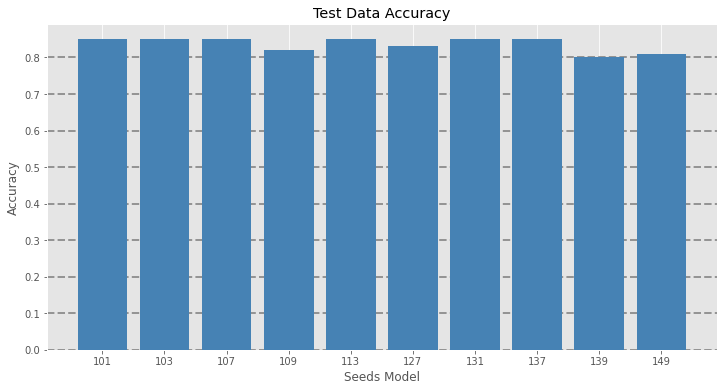

****************************************************************************************************
accuracies :  [0.85, 0.85, 0.85, 0.82, 0.85, 0.83, 0.85, 0.85, 0.8, 0.81]
Mean accuracy :  0.836
Best Model Classification Report :
              precision    recall  f1-score   support

           0       0.67      0.90      0.77        20
           1       1.00      0.80      0.89        20
           2       0.90      0.95      0.93        20
           3       1.00      0.70      0.82        20
           4       0.82      0.90      0.86        20

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100



In [ ]:
fig = plt.figure(figsize=(12,6))
plt.bar([str(i) for i in seeds], accs, color='steelblue')
plt.grid(color='gray', linestyle='--', linewidth=2, axis='y', alpha=0.8)
plt.xlabel('Seeds Model')
plt.ylabel('Accuracy')
plt.title('Test Data Accuracy')
plt.show()
print("*"*100)
print("accuracies : ", accs)
print("Mean accuracy : ",np.array(accs).mean())
print("Best Model Classification Report :")
print(clfrep[np.array(accs).argmax()])